In [1]:
from unityagents import UnityEnvironment
import random
import torch

import torch.nn.functional as F
import torch.nn as nn
import RAdam

import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="Banana.x86")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


# Model

In [36]:
class Qnet(nn.Module):
    """Neural Network for State - Action policy"""
    
    def __init__(self, state_size, action_size, seed, fc1_n=256, fc2_n=256):
        """Initialize model parameters and architecture"""
        
        super(Qnet, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_n)
        self.fc2 = nn.Linear(fc1_n, fc2_n)
        self.fc3 = nn.Linear(fc2_n, action_size)
        self.relu = nn.ReLU() 
        
    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# ReplayBuffer

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples"""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['state', 'action', 
                                                                'reward', 'next_state', 
                                                                'done', 'td_error'])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done, td_error):
        """Add a new experience to memory"""
        e = self.experience(state, action, reward, next_state, done, td_error)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        if len(self.memory) > self.batch_size:
            experiences = []
            number_of_slices = int(2**3) # Always be a multiplier of 2 so it doesn't give an error with the batch_size
            for n in range(0, number_of_slices):
                experience_len = int(self.batch_size/number_of_slices)
                randint = random.randint(0, int(len(self.memory) - (experience_len)))
                for i in range(randint, randint+experience_len):
                    experiences.append(self.memory[i])
        else:
            experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)      

In [7]:
# STANDARD
class ReplayBufferStandard:
    """Fixed-size buffer to store experience tuples"""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['state', 'action', 
                                                                'reward', 'next_state', 
                                                                'done', 'average_score'])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done, average_score):
        """Add a new experience to memory"""
        e = self.experience(state, action, reward, next_state, done, average_score)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)      

# Agent

In [8]:
class Agent():
    """Agent that uses BananaBrain to interact with the environment"""
    
    def __init__(self, state_size, action_size, seed, 
                 lr, buffer_size, batch_size, update_every, gamma, tau, 
                 rBuffer='standard', fc1_n=256, fc2_n=256):
        """
        Initialize Agent
        
        Params:
        state_size(int): dimension of each state
        action_size(int): dimension of each action
        seed(int): random seed for reproducing results
        lr: learning rate
        buffer_size: ReplayBuffer buffer_size
        batch_size: batch size for ReplayBuffer every time it's sampled
        update_every: Learn every update_every steps
        gamma, tau: gamma, tau
        rBuffer: class of ReplayBuffer
        fc1_n, fc2_n: number of neurons for the fully connected neural network
        """
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.update_every = update_every
        self.batch_size = batch_size
        self.gamma = gamma
        # Q-networks
        self.qnet_local = Qnet(state_size, action_size, seed, fc1_n=fc1_n, fc2_n=fc2_n).to(device)
        self.qnet_target = Qnet(state_size, action_size, seed, fc1_n=fc1_n, fc2_n=fc2_n).to(device)
        self.optimizer = RAdam.RAdam(self.qnet_local.parameters(), lr=lr)
        
        # Replay memory
        if rBuffer == 'modified':
            print('Using modified ReplayBuffer')
            self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        else:
            self.memory = ReplayBufferStandard(action_size, buffer_size, batch_size, seed)
        self.t_step = 0
      
    def step(self, state, action, reward, next_state, done, average_score):
        
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done, average_score)
        
        # Learn every update_every
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0 and len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)
    
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnet_local.eval()
        with torch.no_grad():
            action_values = self.qnet_local(state)
        self.qnet_local.train()
        
        # Greedy Epsilon Action Selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        
        Q_targets_next = self.qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        Q_expected = self.qnet_local(states).gather(1, actions)
        
        loss = F.mse_loss(Q_expected, Q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network
        for target_param, local_param in zip(self.qnet_target.parameters(), self.qnet_local.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# DQN

In [9]:
def dqn(n_episodes=200, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, train_mode=True, 
        ckpt_path='checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train_mode (bool): if 'True' set environment to training mode
        
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    moving_avgs = []                   # list of moving averages
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        state = env_info.vector_observations[0]                 # get current state        
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                      # select an action
            env_info = env.step(action)[brain_name]             # send action to environment
            next_state = env_info.vector_observations[0]        # get next state
            reward = env_info.rewards[0]                        # get reward
            done = env_info.local_done[0]                       # see if episode has finished
            score += reward
            average_score = score / (t+1)
            agent.step(state, action, reward, next_state, done, average_score) # learning step
            state = next_state
            
            if done:
                break 
        scores_window.append(score)          # save most recent score to window
        scores.append(score)                 # save most recent score to total
        moving_avg = np.mean(scores_window)  # calculate moving average
        moving_avgs.append(moving_avg)       # save most recent moving average
        eps = max(eps_end, eps_decay*eps)    # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}\t Epsilon: {}'.format(i_episode, moving_avg, eps), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {}'.format(i_episode, moving_avg, eps))
            if eps == eps_end:
                eps *= 5 # Bump the epsilon at every new 100 episodes
        if moving_avg >= 13.0:
            print(f'\nThe Agent has solved the Environment in {i_episode} episodes.')
            print(f'\nAverage Score for the last 100 episodes: {moving_avg}')
            if train_mode:
                torch.save(agent.qnet_local.state_dict(), ckpt_path)
            break
    return scores, moving_avgs

# Hyperparameters

In [39]:
buffer_size = int(1e5)
batch_size = 128
gamma = 0.99 # discount factor
tau = 1e-3 # soft update of target parameters
update_every = 4 # how often to update the network
eps_start = 1.0 # epsilon starting value
eps_decay = 0.96 # epsilon decay
eps_end = 0.01 # minimum epsilon
max_t = 1000 # maximum number of steps in an episode
lr = 1e-5 # learning rate
n_hidden = 2048

# Train

lr: 1e-05, n_hidden: 2048, max_t: 1000
Using modified ReplayBuffer
Episode 100	Average Score: 4.98	Epsilon: 0.016870319358849588
Episode 200	Average Score: 11.20	Epsilon: 0.011336609280436398
Episode 300	Average Score: 12.10	Epsilon: 0.0110175320393506247
Episode 380	Average Score: 13.06	 Epsilon: 0.010175320393506247
The Agent has solved the Environment in 380 episodes.

Average Score for the last 100 episodes: 13.06


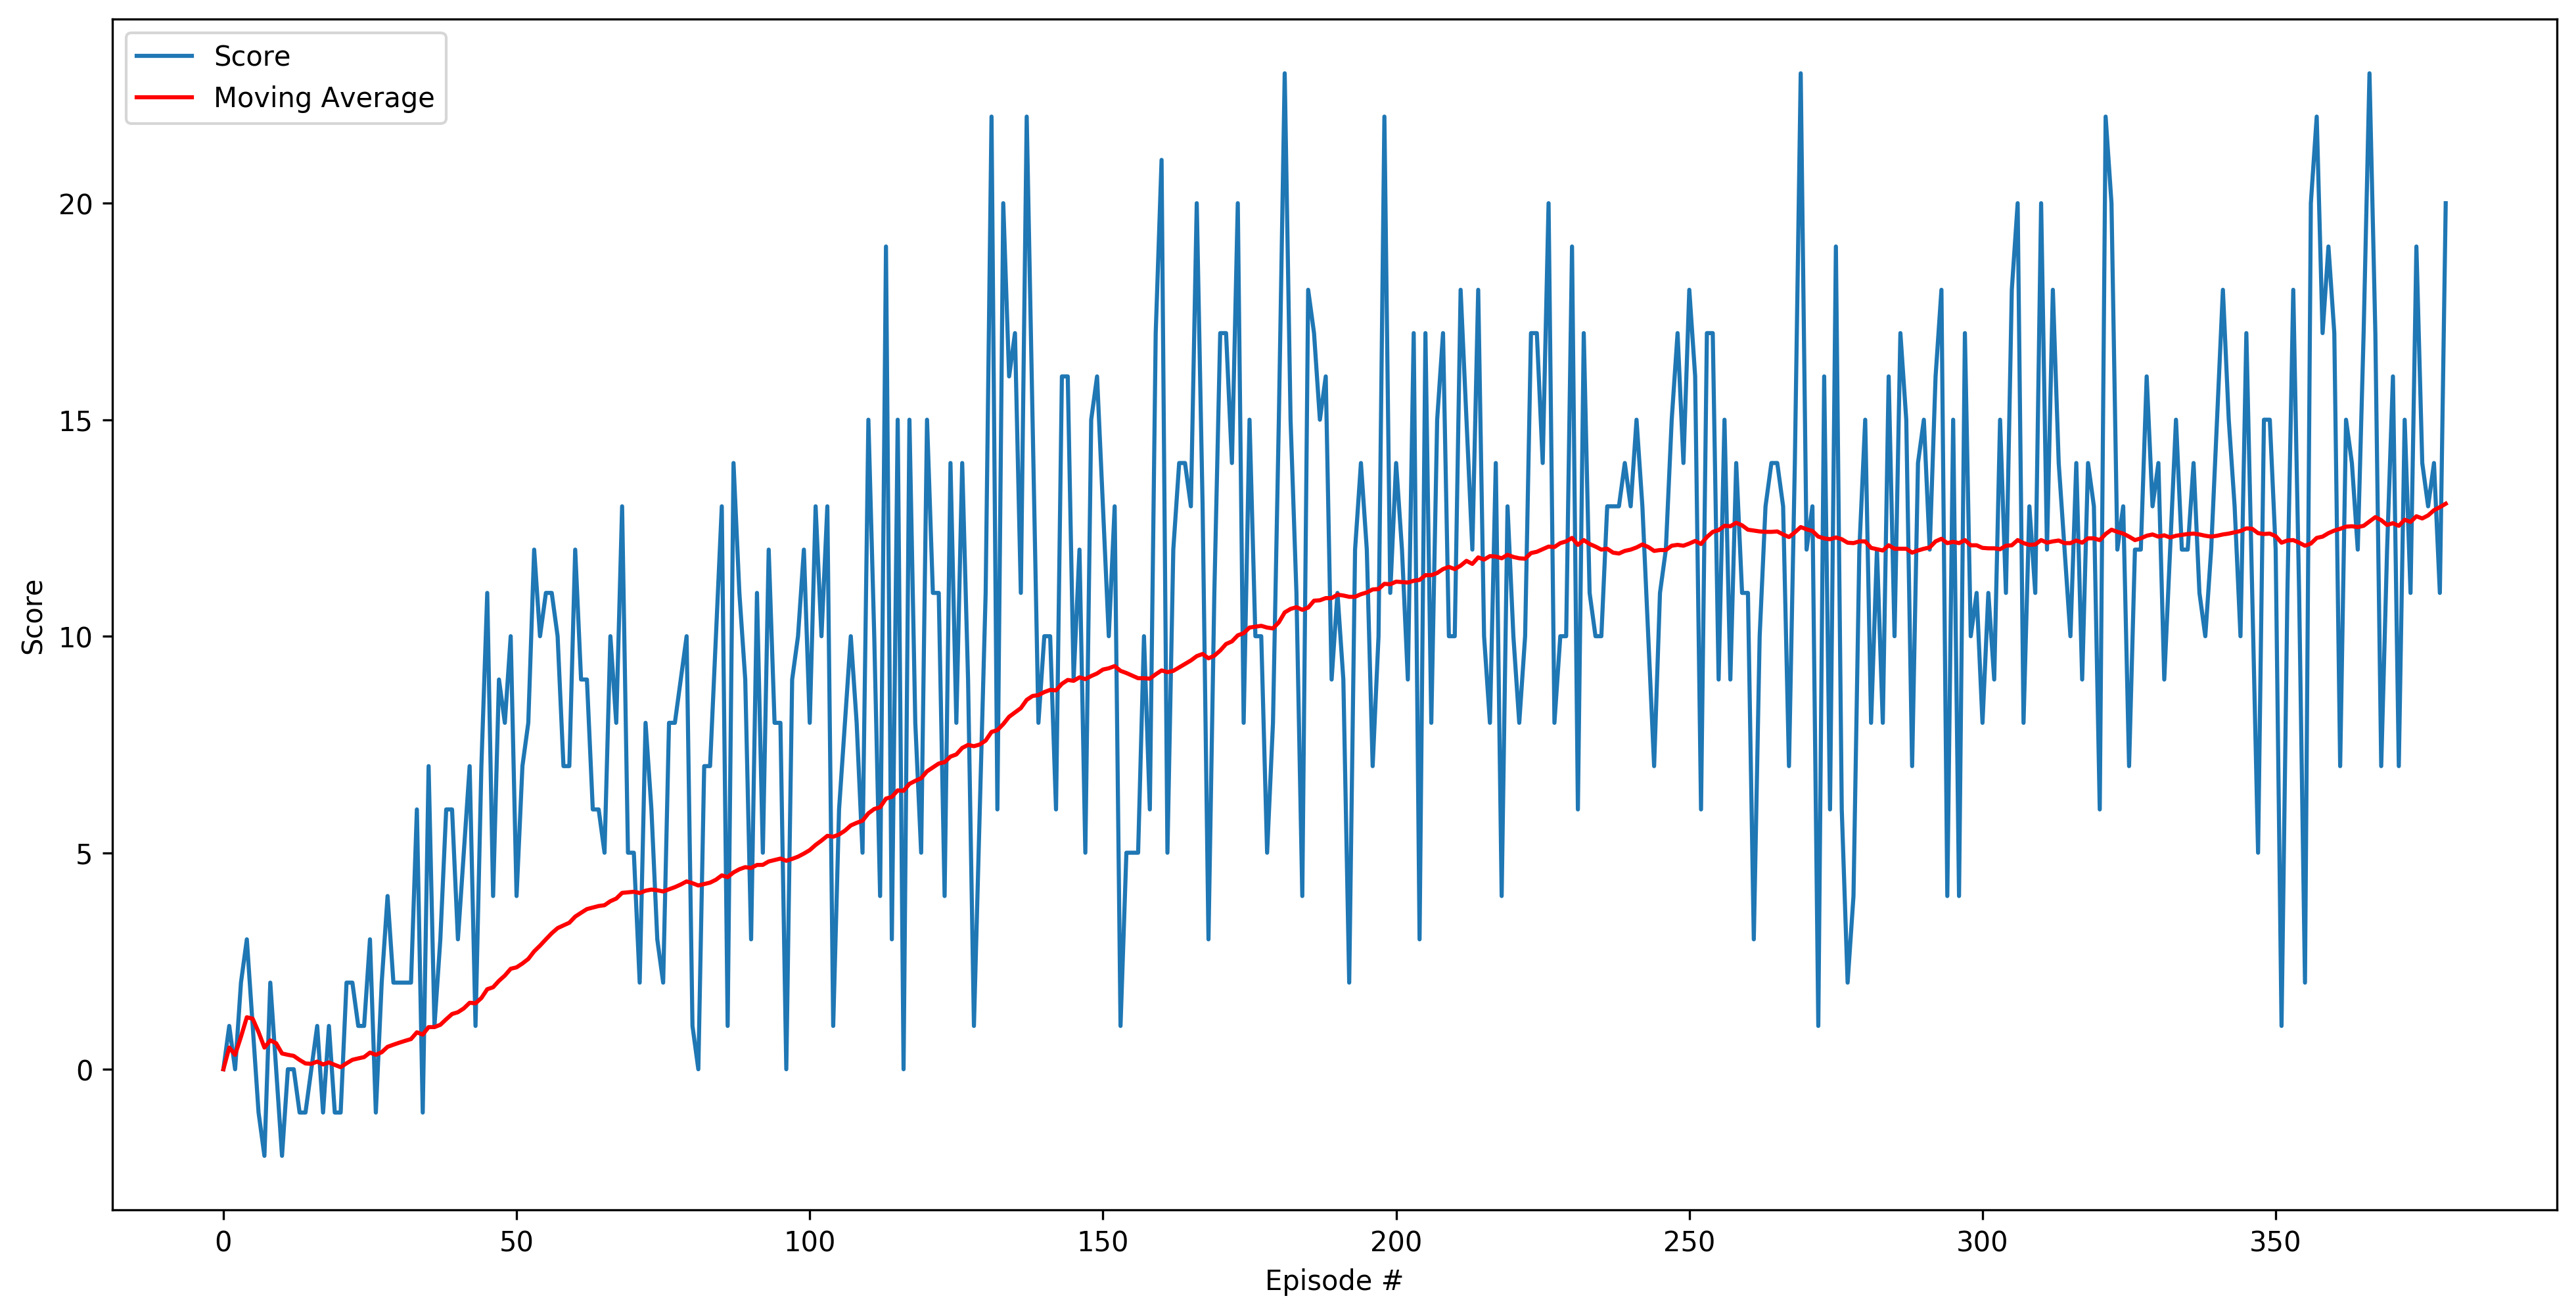

In [41]:
print(f'lr: {lr}, n_hidden: {n_hidden}, max_t: {max_t}')
agent = Agent(state_size=state_size, action_size=action_size, seed=100, 
              lr=lr, buffer_size=buffer_size, batch_size=batch_size, 
              gamma=gamma, tau=tau, update_every=update_every, rBuffer='modified',
             fc1_n=n_hidden, fc2_n=n_hidden)

scores, avgs = dqn(n_episodes=500, max_t=max_t, 
                   eps_decay=eps_decay, eps_end=eps_end, 
                   ckpt_path='checkpoint_modified.pth')

# plot the scores
fig = plt.figure(figsize=(16,8),dpi=300)
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Score')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

lr: 1e-05, n_hidden: 2048, max_t: 1000
Episode 100	Average Score: 4.45	Epsilon: 0.016870319358849588
Episode 200	Average Score: 10.17	Epsilon: 0.011336609280436398
Episode 300	Average Score: 12.50	Epsilon: 0.0110175320393506247
Episode 383	Average Score: 13.03	 Epsilon: 0.010175320393506247
The Agent has solved the Environment in 383 episodes.

Average Score for the last 100 episodes: 13.03


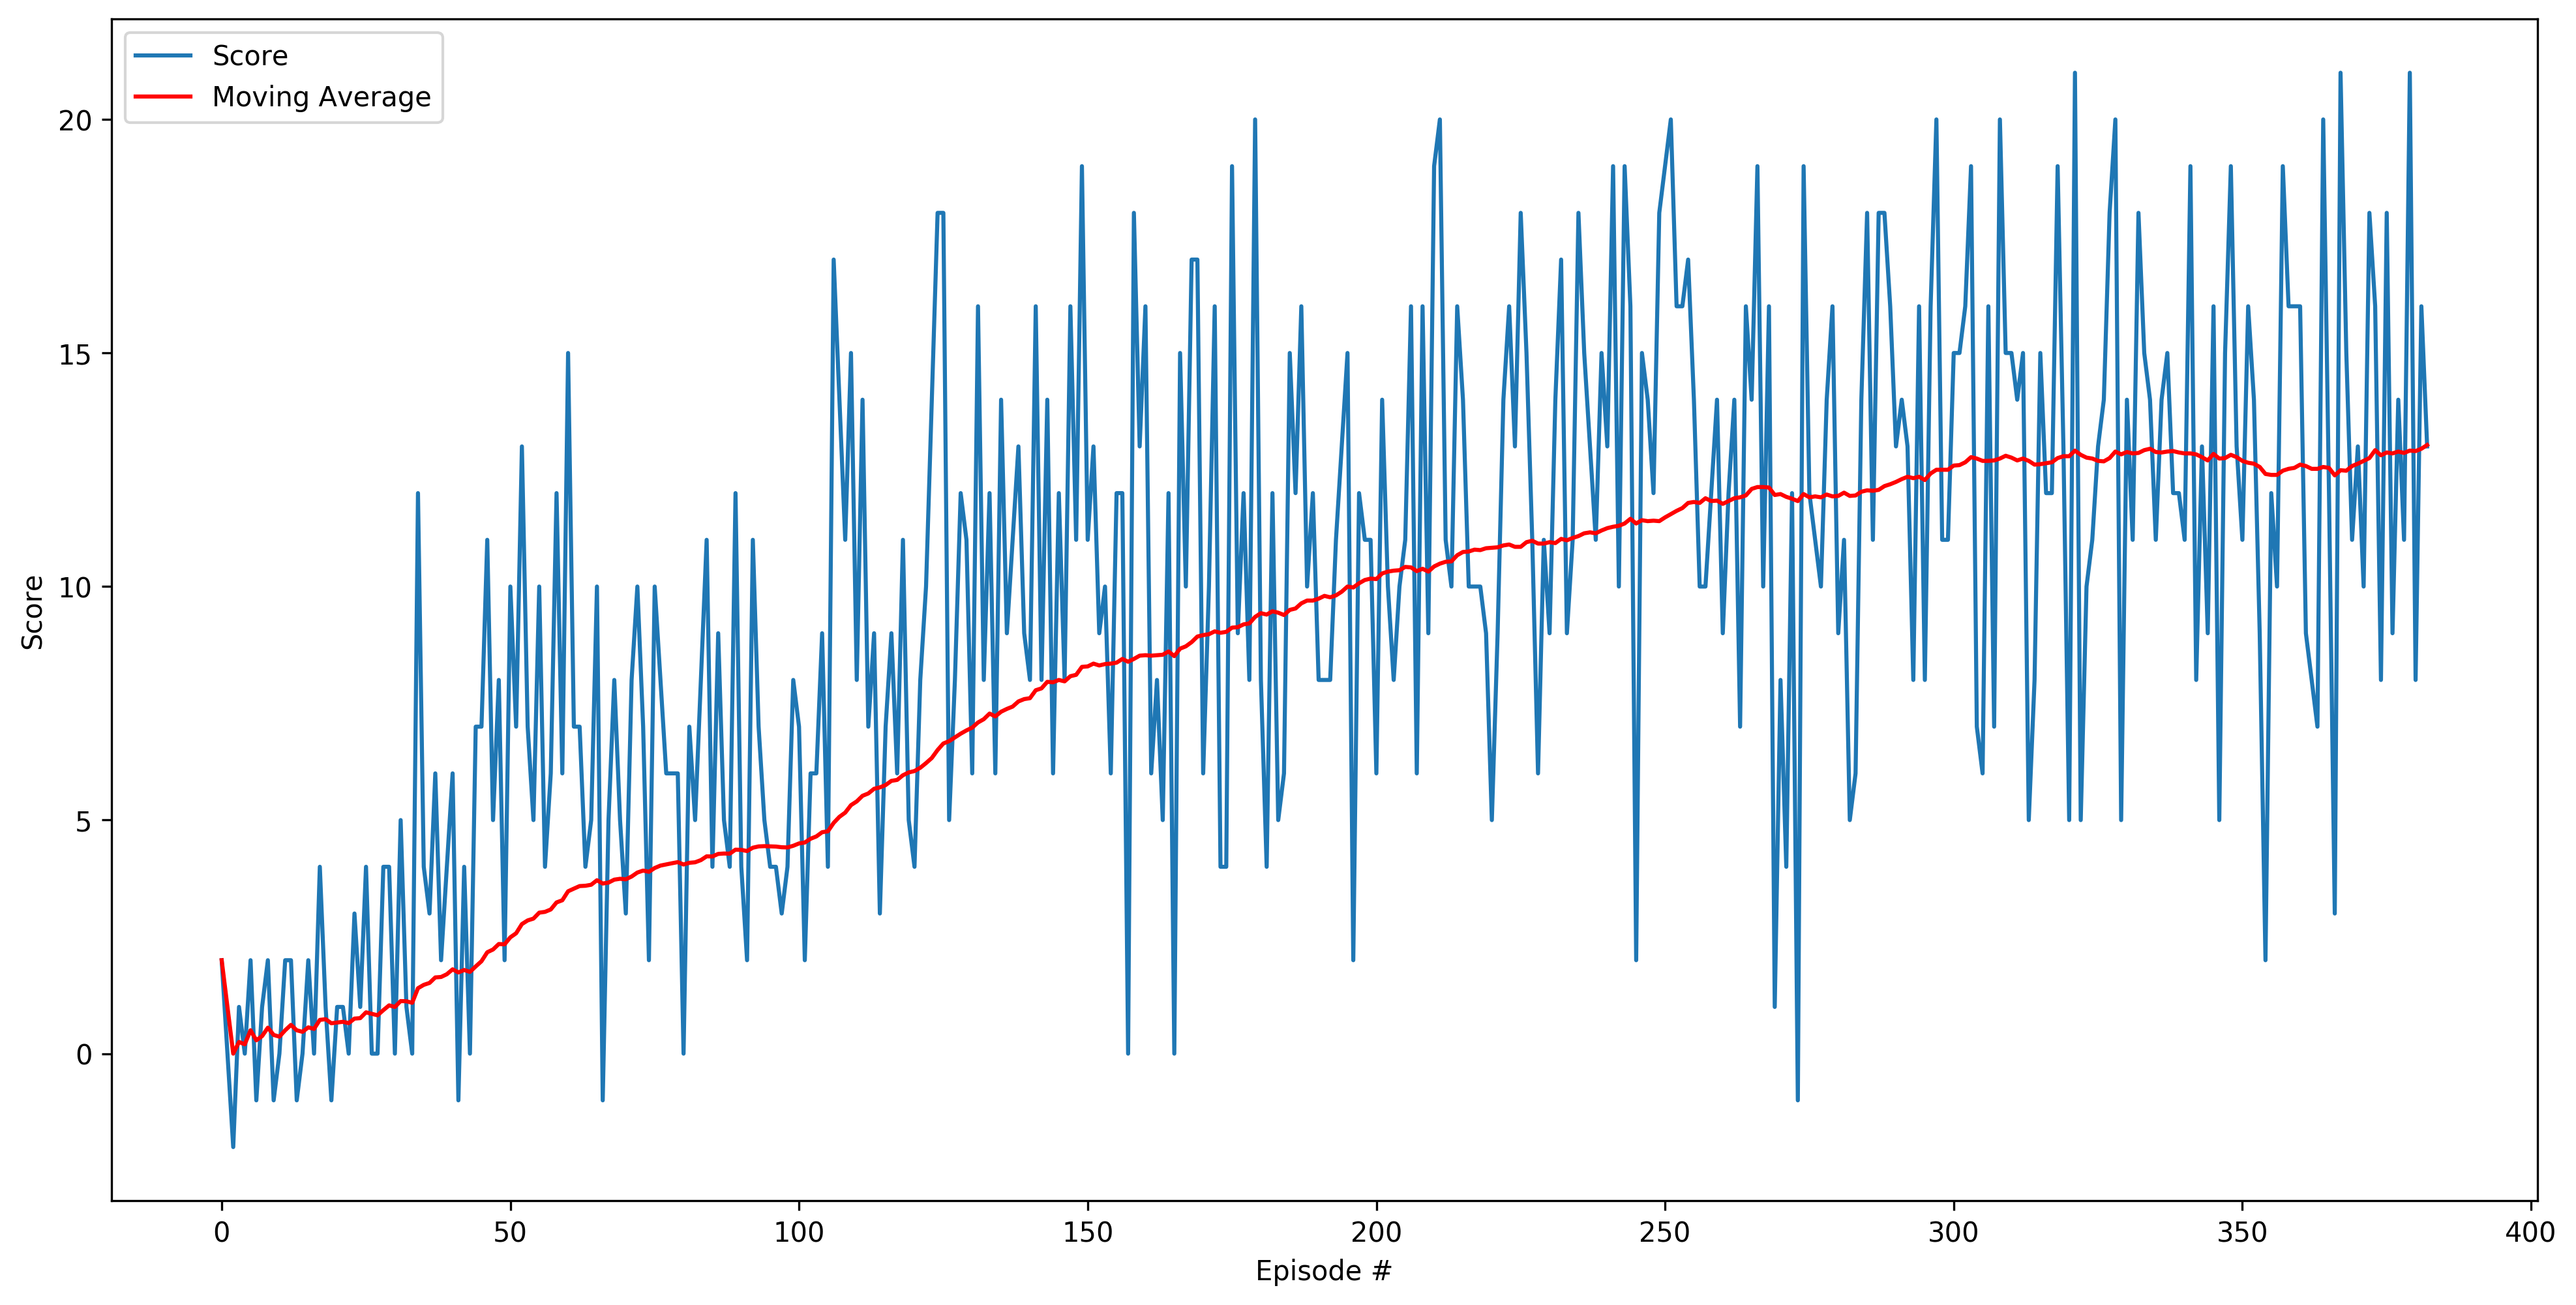

In [42]:
print(f'lr: {lr}, n_hidden: {n_hidden}, max_t: {max_t}')
agent = Agent(state_size=state_size, action_size=action_size, seed=100, 
              lr=lr, buffer_size=buffer_size, batch_size=batch_size, 
              gamma=gamma, tau=tau, update_every=update_every, rBuffer='standard',
              fc1_n=n_hidden, fc2_n=n_hidden)

scores, avgs = dqn(n_episodes=500, max_t=max_t, 
                   eps_decay=eps_decay, eps_end=eps_end, 
                   ckpt_path='checkpoint_standard.pth')

# plot the scores
fig = plt.figure(figsize=(16,8),dpi=300)
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Score')
plt.plot(np.arange(len(scores)), avgs, c='r', label='Moving Average')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [54]:
env.close()

# Play Trained Agent

In [53]:
scores, avgs = dqn(n_episodes=1, eps_start=0.01, eps_end=0.01, max_t=2000, train_mode=False)

Episode 1	Average Score: 18.00	 Epsilon: 0.01
The Agent has solved the Environment in 1 episodes.

Average Score for the last 100 episodes: 18.0


# ReplayBuffer Research

In [7]:
memory = deque(maxlen=100)
exp = namedtuple('Exp', field_names=['field1', 'reward'])

In [11]:
# x - min(x) / max(x) - min(x)

In [89]:
n = 0
td_error = random.random() * 10 - 5
# reward = random.randint(0,10)
# average_score = random.randint(1,20)

experience = (n, td_error)
memory.append(experience)
min_mem = min(memory)
max_mem = max(memory)
# print(memory)

min_mem = min(memory,key=lambda item:item[1])[1]
max_mem = max(memory,key=lambda item:item[1])[1]
print(['min mem:', min_mem], ['max mem:', max_mem])

['min mem:', -4.9503477357386245] ['max mem:', 4.907897413422699]


In [97]:
memory_slice = []
for i in range(5, 15):
    memory_slice.append(memory[i])
    
mem_slice = [memory[i] for i in range(5, 15)]
print(mem_slice)

[(0, 3.6256672677160697), (0, 1.484738490115265), (0, -4.9503477357386245), (0, -2.3395431530875777), (0, -4.8410754448289754), (0, -2.7157922220171704), (0, 3.535039195384302), (0, -1.8940711934719912), (0, -1.8151731013329808), (0, 1.025666466616853)]
